# Abstractive versus Extractive

In [1]:
import torch, transformer_lens, itertools
from measureLM import visualizing, decoding, patching, scoring
from functools import partial
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  

In [2]:
model = transformer_lens.HookedTransformer.from_pretrained("gpt2-medium").to("cpu")
model.cfg.spacing = "Ġ"
model.tokenizer.pad_token = model.tokenizer.eos_token

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-medium into HookedTransformer
Moving model to device:  cpu


In [19]:
## encoding
token_candidates = ["Paris", "France", "Poland", "Warsaw"]
prompts = [("Q: What is the capital of France? A: Paris Q: What is the capital of Poland? A:",
            'Q: What is the capital of Poland? Options: "A" Berlin, "B" Warsaw, "C" Paris A:')]

i = 1
logits, activs, tokens = decoding.encode(prompts[0][i], model)
pred = model.tokenizer.convert_ids_to_tokens(torch.topk(logits[:,-1,:], k=10).indices.tolist()[0])
print(pred, (len(tokens[0])))

['ĠCapital', 'ĠThe', 'Ġ"', 'ĠBerlin', 'Ġ$', 'Ġ1', 'ĠâĤ¬', 'ĠA', 'ĠPoland', 'ĠPolish'] 27


In [20]:
def token_select(layer_token_vec, tok_type="last"):
    if tok_type == "last":
        layer_token_vec = layer_token_vec[...,-1].squeeze().detach()
    if tok_type == "mean":
        layer_token_vec = layer_token_vec.mean(-1).squeeze().detach()
    return layer_token_vec

In [25]:
def get_distance(model, activs, mod="resid_post", norm=False, tok_type="last"):    
    
    mod_layer_norms = {}
    pdist = torch.nn.PairwiseDistance(p=2)
    cos_sim = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
    
    layer_norms = []
    for layer in range(1,model.cfg.n_layers):
        
        mod_name_0 = transformer_lens.utils.get_act_name(mod, layer-1)
        mod_activs_0 = activs[mod_name_0]
        mod_name_1 = transformer_lens.utils.get_act_name(mod, layer)
        mod_activs_1 = activs[mod_name_1]

        if norm:
            mod_activs_0 = torch.nn.functional.normalize(mod_activs_0, p=2.0, dim=-1)
            mod_activs_1 = torch.nn.functional.normalize(mod_activs_1, p=2.0, dim=-1)

        #activs_dist = 1-cos_sim(mod_activs_0, mod_activs_1)
        activs_dist = pdist(mod_activs_0, mod_activs_1)
        activs_dist = token_select(activs_dist, tok_type=tok_type)

        layer_norms.append(activs_dist)
    mod_layer_norms = torch.stack(layer_norms).squeeze().numpy()
    return mod_layer_norms
    
mod="resid_post"
mod_layer_dist = get_distance(model, activs, mod=mod, norm=True, tok_type="last")
mod_layer_dist

array([0.11594249, 0.11433549, 0.13801114, 0.1443242 , 0.16801415,
       0.21101947, 0.17475204, 0.17895742, 0.18300813, 0.19333848,
       0.18068323, 0.19526069, 0.1609905 , 0.20380336, 0.20512238,
       0.17147526, 0.18573529, 0.18268692, 0.14643654, 0.14787737,
       0.18795463, 0.19781761, 0.36712584], dtype=float32)

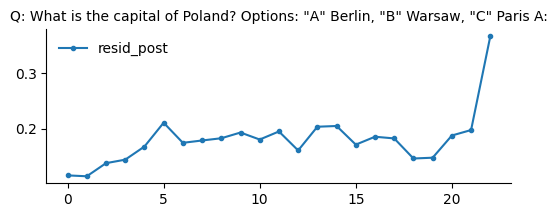

In [28]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from measureLM import helpers

matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False


fig, ax = plt.subplots(1, 1, figsize=(6, 2), gridspec_kw={'hspace': 0.4})

layers = np.array(list(range(0,model.cfg.n_layers-1)))
lines = ax.plot(layers, mod_layer_dist, marker=".", label=mod)

ax.set_title(prompts[0][i], fontsize=10, color="black", loc='center')
ax.legend(frameon=False)


prompt 0
layer 23: [(0.0769, 'Berlin'), (1.0, 'Warsaw'), (0.25, 'Paris'), (0.5, 'Poland')]


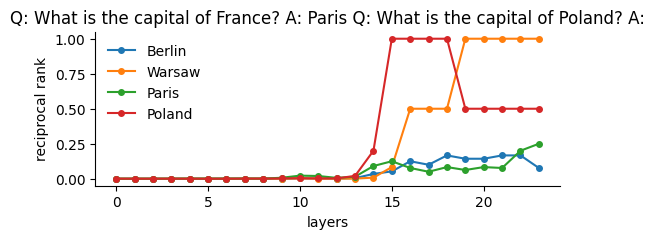

In [16]:
layer_scores = decoding.early_decoding(activs, model)
token_candidates = ["Berlin", "Warsaw", "Paris", "Poland"]

tok_idx = scoring.token_select(tokens, model)
scored_tokens = scoring.scores_to_tokens(layer_scores, tok_idx, model, mode=token_candidates)
visualizing.visualize_token_ranks(scored_tokens, token_candidates, prompts[0])

In [114]:
model.tokenizer.convert_ids_to_tokens(tokens[tok_idx])

[':']